In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm, tnrange

In [3]:
# Ensure results are reproducable
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
def mnist_load_data(path='mnist.npz'):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
    return (x_train, y_train), (x_test, y_test)
        

(X_train, y_train), (X_test, y_test) = mnist_load_data(path='../input/mnist.npz')

In [5]:
X_train = np.expand_dims(X_train,1)
X_test = np.expand_dims(X_test,1)

In [6]:
from sklearn.utils import resample

In [7]:
X_train, y_train = resample(X_train,y_train,n_samples=50000)

In [8]:
X_train.shape

(50000, 1, 28, 28)

In [23]:
X_train = X_train/255
X_test = X_test/255

In [24]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import LeakyReLU, Reshape
from keras.layers import Conv2D, UpSampling2D
from keras.optimizers import Adam

from keras.initializers import RandomNormal

In [25]:
import keras.backend as K
K.set_image_data_format('channels_first')

In [26]:
latent_dim = 100

In [27]:
generator = Sequential() #1 

generator.add(Dense(128*7*7, 
                    input_dim=latent_dim, 
                    kernel_initializer=RandomNormal(stddev=0.02))) #2

generator.add(LeakyReLU(0.2)) #3
generator.add(Reshape((128, 7, 7))) #4
generator.add(UpSampling2D(size=(2, 2))) #5

generator.add(Conv2D(64,kernel_size=(5, 5),padding='same')) #6

generator.add(LeakyReLU(0.2)) #7
generator.add(UpSampling2D(size=(2, 2))) #8

generator.add(Conv2D(1, kernel_size=(5, 5),
                        padding='same', 
                        activation='tanh')) #9
  
adam = Adam(lr=0.0002, beta_1=0.5)                      
generator.compile(loss='binary_crossentropy', optimizer=adam) #10

In [28]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 128, 7, 7)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 128, 14, 14)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 14, 14)        204864    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 14, 14)        0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 64, 28, 28)        0         
__________

In [29]:
# Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), 
                         strides=(2, 2), 
                         padding='same', 
                         input_shape=(1, 28, 28),
                         kernel_initializer=RandomNormal(stddev=0.02))) #1

discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), 
                         strides=(2, 2), 
                         padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3)) #2
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [30]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 14, 14)        1664      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 64, 14, 14)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 14, 14)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 7, 7)         204928    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 128, 7, 7)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 7, 7)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
__________

In [31]:
discriminator.trainable = False #1
ganInput = Input(shape=(latent_dim,)) #2
x = generator(ganInput) #3
ganOutput = discriminator(x) #4
gan = Model(inputs=ganInput, outputs=ganOutput) #5
gan.compile(loss='binary_crossentropy', optimizer=adam) #6

In [32]:
X_train.shape[0]

50000

In [33]:
def show_gen():
    r, c = 2, 2
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)
    print(gen_imgs.shape)
    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 1

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, 0,:,:], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    #fig.savefig("images/mnist_%d.png" % epoch)
    plt.show()
    return gen_imgs

(4, 1, 28, 28)


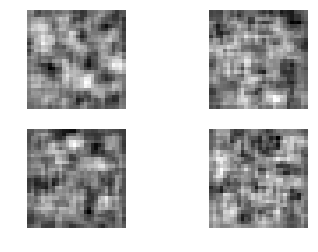

In [34]:
i = show_gen()

--------------- Epoch 1 ---------------
dLoss: 0.46
gLoss: 1.11
(4, 1, 28, 28)


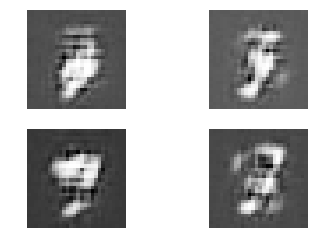

--------------- Epoch 2 ---------------
dLoss: 0.35
gLoss: 1.54
(4, 1, 28, 28)


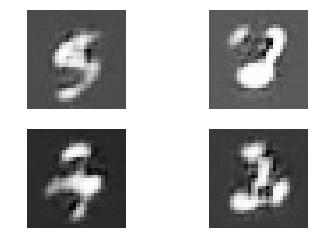

--------------- Epoch 3 ---------------
dLoss: 0.34
gLoss: 1.66
(4, 1, 28, 28)


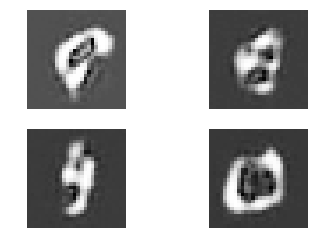

--------------- Epoch 4 ---------------
dLoss: 0.33
gLoss: 1.74
(4, 1, 28, 28)


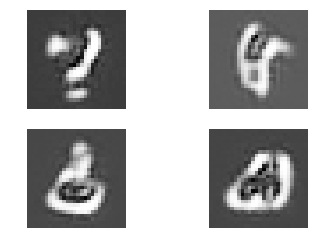

--------------- Epoch 5 ---------------
dLoss: 0.33
gLoss: 1.78
(4, 1, 28, 28)


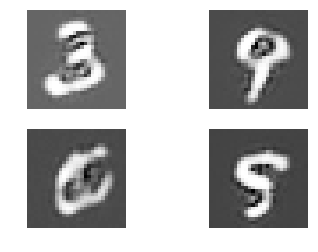

--------------- Epoch 6 ---------------
dLoss: 0.32
gLoss: 1.83
(4, 1, 28, 28)


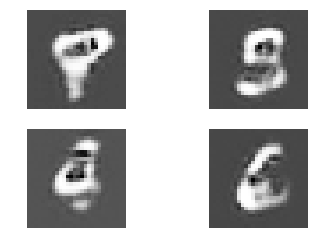

--------------- Epoch 7 ---------------
dLoss: 0.32
gLoss: 1.89
(4, 1, 28, 28)


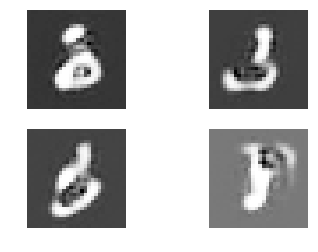

--------------- Epoch 8 ---------------
dLoss: 0.31
gLoss: 1.93
(4, 1, 28, 28)


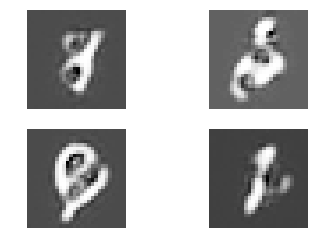

--------------- Epoch 9 ---------------
dLoss: 0.31
gLoss: 1.95
(4, 1, 28, 28)


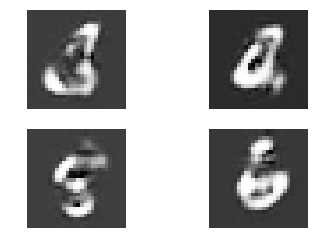

--------------- Epoch 10 ---------------
dLoss: 0.31
gLoss: 1.99
(4, 1, 28, 28)


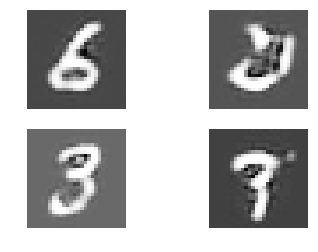

--------------- Epoch 11 ---------------
dLoss: 0.30
gLoss: 2.02
(4, 1, 28, 28)


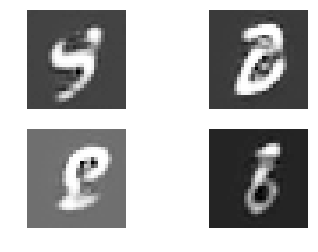

--------------- Epoch 12 ---------------
dLoss: 0.30
gLoss: 2.05
(4, 1, 28, 28)


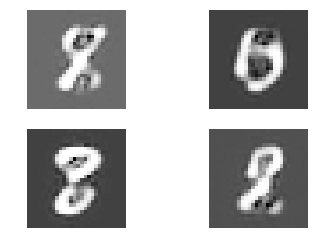

--------------- Epoch 13 ---------------
dLoss: 0.29
gLoss: 2.09
(4, 1, 28, 28)


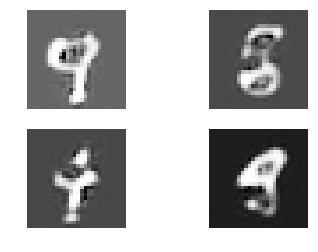

--------------- Epoch 14 ---------------
dLoss: 0.29
gLoss: 2.12
(4, 1, 28, 28)


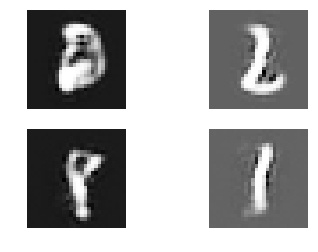

--------------- Epoch 15 ---------------
dLoss: 0.29
gLoss: 2.12
(4, 1, 28, 28)


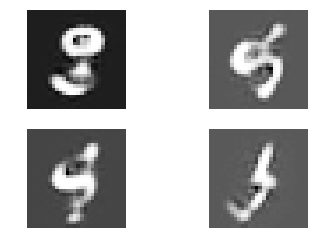

--------------- Epoch 16 ---------------
dLoss: 0.28
gLoss: 2.15
(4, 1, 28, 28)


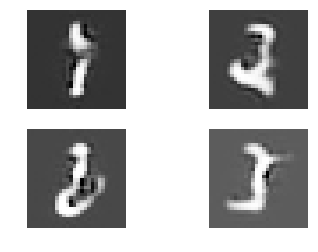

--------------- Epoch 17 ---------------
dLoss: 0.28
gLoss: 2.19
(4, 1, 28, 28)


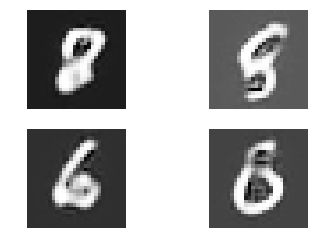

--------------- Epoch 18 ---------------
dLoss: 0.28
gLoss: 2.20
(4, 1, 28, 28)


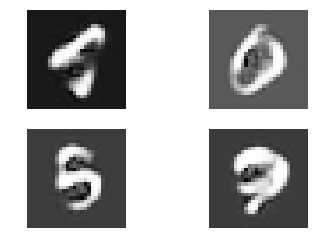

--------------- Epoch 19 ---------------
dLoss: 0.28
gLoss: 2.21
(4, 1, 28, 28)


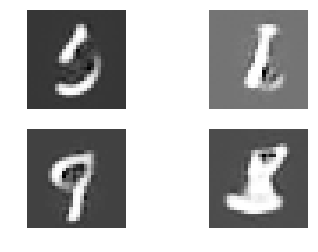

--------------- Epoch 20 ---------------
dLoss: 0.28
gLoss: 2.23
(4, 1, 28, 28)


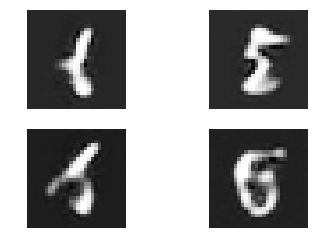

--------------- Epoch 21 ---------------
dLoss: 0.28
gLoss: 2.25
(4, 1, 28, 28)


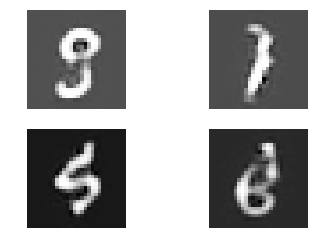

--------------- Epoch 22 ---------------
dLoss: 0.27
gLoss: 2.28
(4, 1, 28, 28)


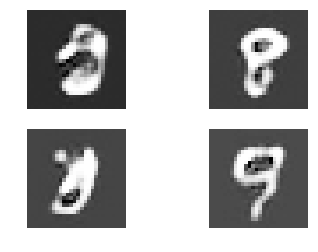

--------------- Epoch 23 ---------------
dLoss: 0.27
gLoss: 2.27
(4, 1, 28, 28)


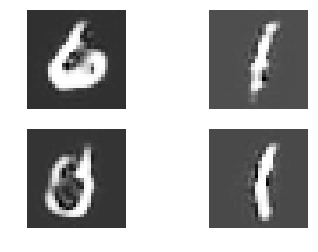

--------------- Epoch 24 ---------------
dLoss: 0.27
gLoss: 2.29
(4, 1, 28, 28)


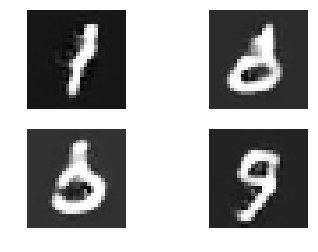

--------------- Epoch 25 ---------------
dLoss: 0.27
gLoss: 2.29
(4, 1, 28, 28)


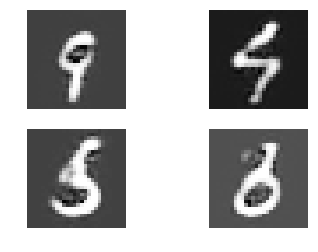

--------------- Epoch 26 ---------------
dLoss: 0.27
gLoss: 2.29
(4, 1, 28, 28)


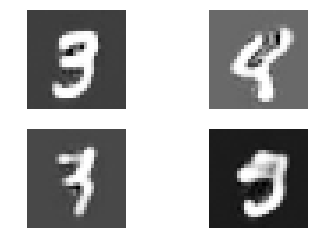

--------------- Epoch 27 ---------------
dLoss: 0.27
gLoss: 2.33
(4, 1, 28, 28)


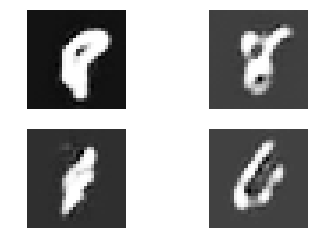

--------------- Epoch 28 ---------------
dLoss: 0.27
gLoss: 2.32
(4, 1, 28, 28)


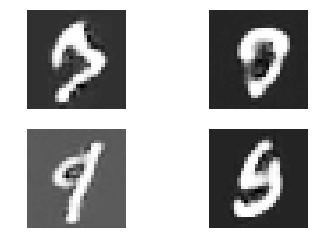

--------------- Epoch 29 ---------------
dLoss: 0.27
gLoss: 2.31
(4, 1, 28, 28)


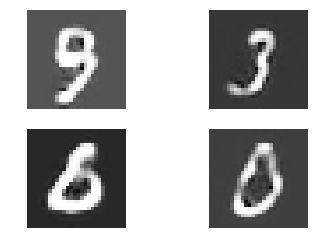

--------------- Epoch 30 ---------------
dLoss: 0.27
gLoss: 2.35
(4, 1, 28, 28)


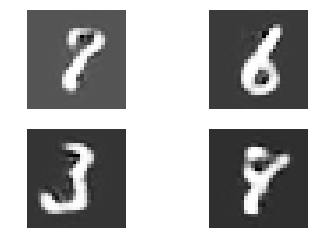

--------------- Epoch 31 ---------------
dLoss: 0.27
gLoss: 2.35
(4, 1, 28, 28)


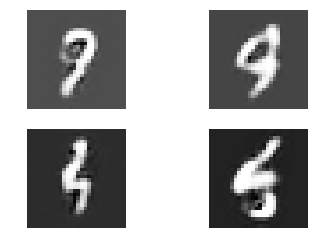

--------------- Epoch 32 ---------------
dLoss: 0.27
gLoss: 2.35
(4, 1, 28, 28)


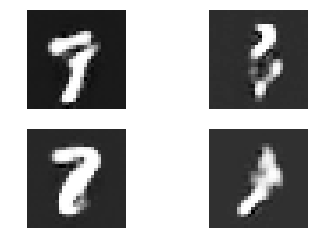

--------------- Epoch 33 ---------------
dLoss: 0.26
gLoss: 2.35
(4, 1, 28, 28)


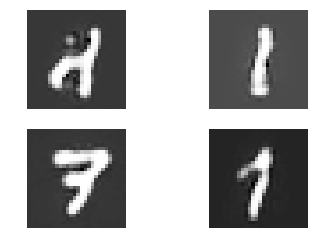

--------------- Epoch 34 ---------------
dLoss: 0.26
gLoss: 2.35
(4, 1, 28, 28)


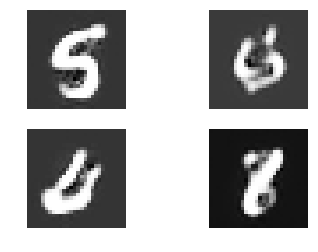

--------------- Epoch 35 ---------------
dLoss: 0.26
gLoss: 2.37
(4, 1, 28, 28)


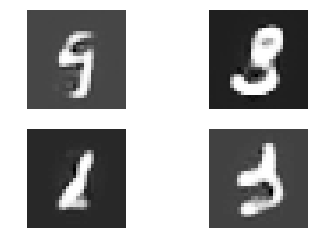

--------------- Epoch 36 ---------------
dLoss: 0.26
gLoss: 2.35
(4, 1, 28, 28)


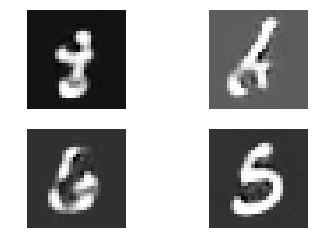

--------------- Epoch 37 ---------------
dLoss: 0.26
gLoss: 2.38
(4, 1, 28, 28)


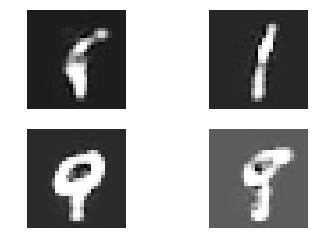

--------------- Epoch 38 ---------------
dLoss: 0.26
gLoss: 2.37
(4, 1, 28, 28)


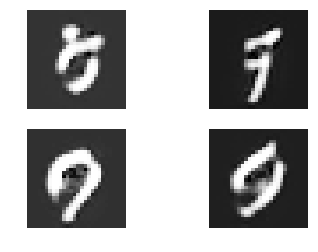

--------------- Epoch 39 ---------------
dLoss: 0.26
gLoss: 2.37
(4, 1, 28, 28)


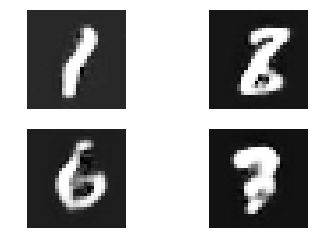

--------------- Epoch 40 ---------------
dLoss: 0.26
gLoss: 2.38
(4, 1, 28, 28)


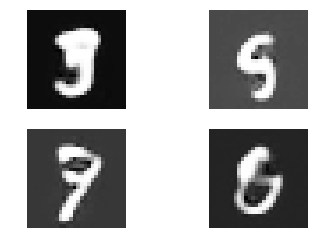

--------------- Epoch 41 ---------------
dLoss: 0.26
gLoss: 2.40
(4, 1, 28, 28)


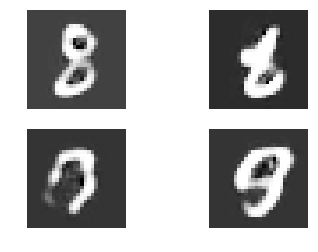

--------------- Epoch 42 ---------------
dLoss: 0.26
gLoss: 2.38
(4, 1, 28, 28)


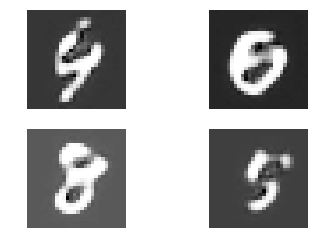

--------------- Epoch 43 ---------------
dLoss: 0.26
gLoss: 2.40
(4, 1, 28, 28)


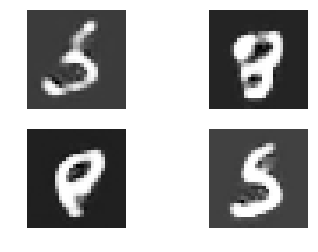

--------------- Epoch 44 ---------------
dLoss: 0.26
gLoss: 2.39
(4, 1, 28, 28)


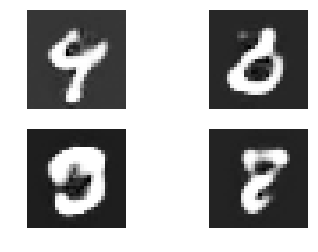

--------------- Epoch 45 ---------------
dLoss: 0.26
gLoss: 2.39
(4, 1, 28, 28)


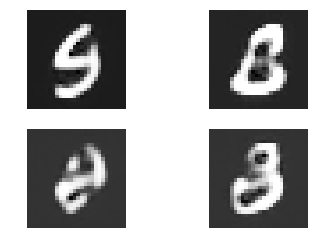

--------------- Epoch 46 ---------------
dLoss: 0.26
gLoss: 2.41
(4, 1, 28, 28)


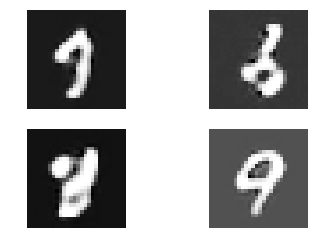

--------------- Epoch 47 ---------------
dLoss: 0.26
gLoss: 2.40
(4, 1, 28, 28)


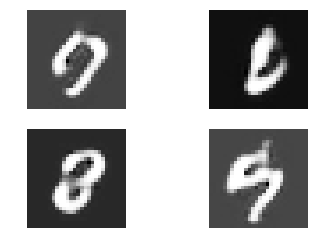

--------------- Epoch 48 ---------------
dLoss: 0.26
gLoss: 2.41
(4, 1, 28, 28)


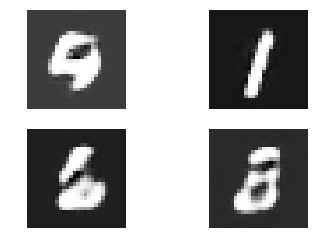

--------------- Epoch 49 ---------------
dLoss: 0.26
gLoss: 2.42
(4, 1, 28, 28)


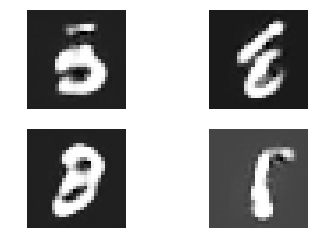

--------------- Epoch 50 ---------------
dLoss: 0.26
gLoss: 2.41
(4, 1, 28, 28)


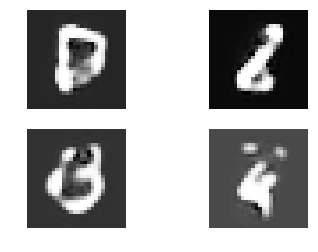

In [35]:
dLosses = []
gLosses = []
epochs=50 
batchSize=128
batchCount = X_train.shape[0] // batchSize #1

for e in range(1, epochs+1): #2
    print('-'*15, 'Epoch %d' % e, '-'*15)
    dloss = 0
    gloss = 0
    for _ in range(batchCount): #3      
        noise = np.random.normal(0, 1, size=[batchSize, latent_dim]) #4
        imageBatch = X_train[np.random.randint(0, 
                                              X_train.shape[0],
                                              size=batchSize)] #5

        generatedImages = generator.predict(noise) #6
        X = np.concatenate([imageBatch, generatedImages]) #7

        yDis = np.zeros(2*batchSize) #8
        yDis[:batchSize] = 0.9 
        
        labelNoise = np.random.random(yDis.shape) #9
        yDis += 0.05 * labelNoise + 0.05

        
        discriminator.trainable = True #10
        dloss += discriminator.train_on_batch(X, yDis) #11

        
        noise = np.random.normal(0, 1, size=[batchSize, latent_dim]) #12
        yGen = np.ones(batchSize) #13
        discriminator.trainable = False #14
        gloss += gan.train_on_batch(noise, yGen) #15
    
    dloss /= batchCount
    gloss /= batchCount
    print('dLoss: {:.2f}'.format(dloss))
    print('gLoss: {:.2f}'.format(gloss))
    #16
    dLosses.append(dloss)
    gLosses.append(gloss)
    show_gen()
    

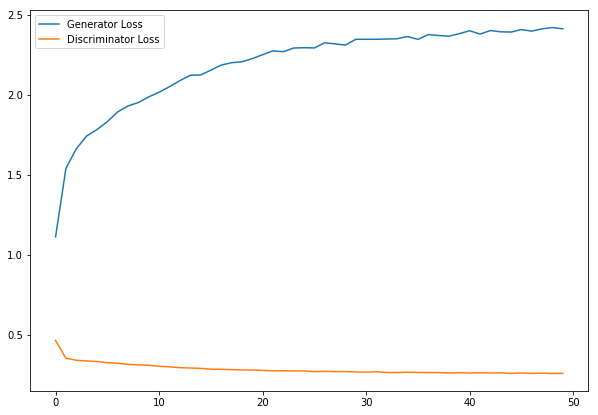

In [47]:
plt.figure(figsize=(10,7))
plt.plot(gLosses,label='Generator Loss')
plt.plot(dLosses, label='Discriminator Loss')
plt.legend()

(4, 1, 28, 28)


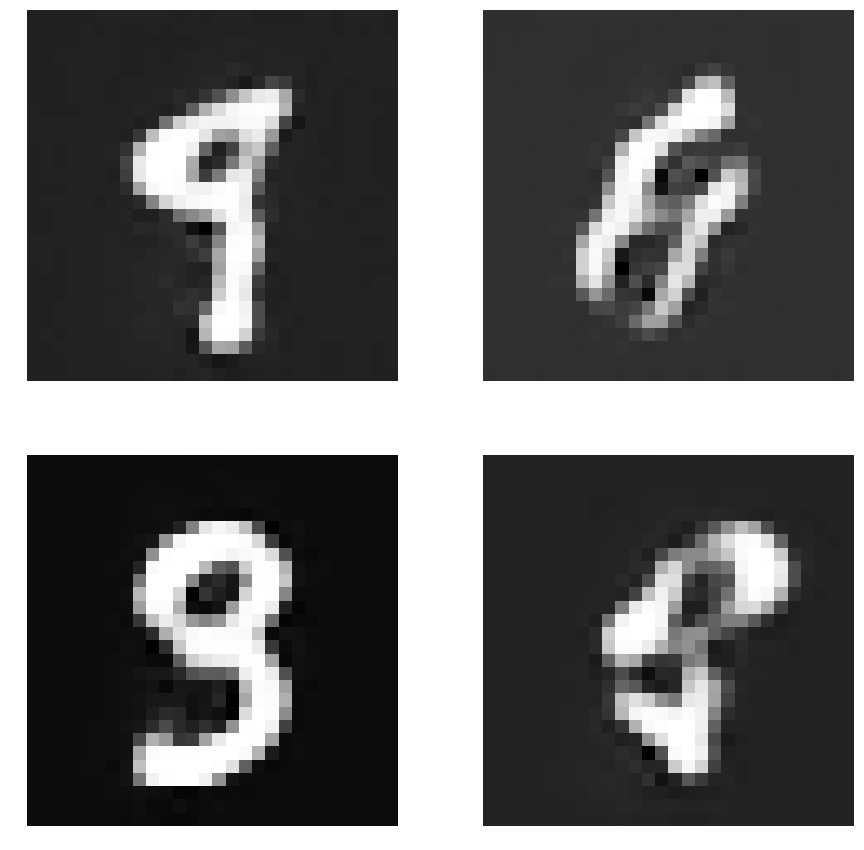

In [56]:
r, c = 2, 2
noise = np.random.normal(0, 1, (r * c, 100))
gen_imgs = generator.predict(noise)
print(gen_imgs.shape)
# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 1

fig, axs = plt.subplots(r, c,figsize=(15,15))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, 0,:,:], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
#fig.savefig("images/mnist_%d.png" % epoch)
plt.show()